In [1]:
#basic
import os
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#torch
import torch; print('\nPyTorch version in use:', torch.__version__, '\ncuda avail: ', torch.cuda.is_available())
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

#torchvision
import torchvision
from torchvision import transforms, datasets

from copy import deepcopy
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect
import shutil
import time
from scipy.io import loadmat

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: %s' % device)


PyTorch version in use: 2.4.1+cu118 
cuda avail:  True


C:\Users\ricig\AppData\Local\Temp\ipykernel_21412\3991163402.py:24: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Device: cuda


In [ ]:
#check data structure
# Load the .mat file
filename = './FRF_ARMA/ARMA_AR20_MA20/FRF_anARMA_AR20_MA20_1.mat'
data = loadmat(filename)

# List all variables
print("Variables in the file:")
print(data.keys())

# Inspect each variable
for var_name in data:
    if var_name.startswith("__"):  # Skip meta variables
        continue
    print(f"\nVariable {var_name}:")
    print(f" Type: {type(data[var_name])}")
    print(f" Shape: {data[var_name].shape}")
    print(f" Data: {data[var_name]}")


In [ ]:
# Load the .mat file
filename = './FRF_ARMA/ARMA_AR20_MA20/FRF_anARMA_AR20_MA20_1.mat'
data = loadmat(filename)

# Extract the 'FRF' variable
frf_data = data['FRF']

# Define the x-axis values from 0 to 50 Hz, equispaced
x_values = np.linspace(0, 50, frf_data.shape[0])

# Calculate the absolute values of the complex numbers in FRF
frf_abs = np.abs(frf_data[:, 0])

# Keep only the first 2/5 of the values (corresponding to 0 to 20 Hz)
num_elements_to_keep = int(frf_abs.shape[0] * 2 / 5)
x_values = x_values[:num_elements_to_keep]
frf_abs = frf_abs[:num_elements_to_keep]

# Plot the absolute values
plt.plot(x_values, frf_abs, label='Magnitude')

# Add labels and title
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Magnitude of First Variable of FRF (0 to 20 Hz)')
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Initialize a list to store results for each file
all_files_data = []

# Iterate through files named as numbers 1.mat to 9.mat
for file_number in range(1, 10):
    filename = f'./FRF_ARMA/ARMA_AR20_MA20/FRF_anARMA_AR20_MA20_{file_number}.mat'  # Construct the file name
    
    # Load the .mat file
    data = loadmat(filename)

    # Extract FRF from the loaded data
    FRF = data['FRF']

    # Calculate the module (magnitude) of the complex values in FRF
    FRF_magnitude = np.abs(FRF)

    # Keep only the first 2/5 elements
    num_elements_to_keep = int(FRF_magnitude.shape[0] * 2 / 5)
    FRF_magnitude = FRF_magnitude[:num_elements_to_keep, :]

    # Append the result for this file to the main list
    all_files_data.append(FRF_magnitude)

# Print a summary of the results
for idx, file_data in enumerate(all_files_data, start=1):
    print(f"File {idx}: Shape of FRF magnitude array: {file_data.shape}")
    print(f"Example from file {idx}: {file_data[0]}")

In [ ]:
# Initialize a list to hold the concatenated arrays for this file
concatenated_arrays = []

# Specify the directory
directory = './FRF_ARMA/ARMA_AR20_MA20/'

# List of filenames
filenames = ['FRF_testARMA_AR20_MA20.mat', 'FRF_trainARMA_AR20_MA20.mat', 'FRF_valARMA_AR20_MA20.mat']

# Iterate through each file in the filenames list
for filename in filenames:
    filepath = os.path.join(directory, filename)  # Construct the full file path

    # Load the .mat file
    data = loadmat(filepath)

    # Extract FRF from the loaded data
    FRF = data['FRF']

    # Calculate the module (magnitude) of the complex values in FRF
    FRF_magnitude = np.abs(FRF)

    # Keep only the first 2/5 elements
    num_elements_to_keep = int(FRF_magnitude.shape[0] * 2 / 5)
    FRF_magnitude = FRF_magnitude[:num_elements_to_keep, :]

    # Append the result for this file to the main list
    concatenated_arrays.append(FRF_magnitude)


merged_array = np.hstack(concatenated_arrays)
# Print the shape of the merged array
print(f"Shape of merged array: {merged_array.shape}")

In [ ]:
def save_arrays_labeled(reshaped_array, output_directory, label):
    # Ensure the output directory exists
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    # Loop through each column in the reshaped array
    for i in range(reshaped_array.shape[1]):
        # Extract the current 819-element array
        single_array = reshaped_array[:, i]
        
        # Define the file name for the output
        file_name = f'{output_directory}/array_{i}_{label}.npy'
        
        # Save the array as a .npy file
        np.save(file_name, single_array)

In [ ]:
output_directory = './FRF_ARMA_AR20_MA20_labeled_data'

# Remove the directory if it exists and create a new one
if os.path.exists(output_directory):
    shutil.rmtree(output_directory)

os.makedirs(output_directory)

# Call the function to save the arrays
for i in range(len(all_files_data)):  # Iterate through indices 0 to 8
    save_arrays_labeled(all_files_data[i], output_directory, i + 1)  # File numbering starts from 1
save_arrays_labeled(merged_array, output_directory, 0)


# If provided dataset, start from here

In [2]:
def load_dataset_and_labels(directory):
    # Initialize lists to hold the data and labels
    data = []
    labels = []

    # Loop through each file in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.npy'):
            # Load the .npy file
            array = np.load(os.path.join(directory, filename))
            
            # Extract the label from the filename
            label = int(filename.split('_')[2].split('.')[0])
            
            # Append the array and label to the respective lists
            data.append(array)
            labels.append(label)
    
    # Convert lists to numpy arrays
    data = np.array(data)
    labels = np.array(labels)
    
    return data, labels

output_directory = './FRF_ARMA_AR20_MA20_labeled_data'
# Call the function to load the dataset and labels
data, labels = load_dataset_and_labels(output_directory)

data = (data - data.mean()) / data.std()

# Print shapes to verify
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)
print(labels)


Data shape: (35169, 819)
Labels shape: (35169,)
[0 1 2 ... 7 8 9]


In [3]:
# Separate the data and labels into majority (label 0) and minority classes
majority_class_data = data[labels == 0]
majority_class_labels = labels[labels == 0]

minority_class_data = data[labels != 0]
minority_class_labels = labels[labels != 0]

# Combine majority data and labels into a single array for undersampling
combined_majority_data = majority_class_data.reshape(-1, majority_class_data.shape[-1])
combined_majority_labels = majority_class_labels

# Set the desired ratio of the majority class to the minority classes
undersample_ratio = len(minority_class_labels) // len(np.unique(minority_class_labels))

# Randomly select indices for undersampling the majority class
undersample_indices = np.random.choice(len(majority_class_data), size=undersample_ratio, replace=False)
majority_class_data_undersampled = majority_class_data[undersample_indices]
majority_class_labels_undersampled = majority_class_labels[undersample_indices]

# Combine the undersampled majority class with the minority classes
data_resampled = np.vstack((majority_class_data_undersampled, minority_class_data))
labels_resampled = np.hstack((majority_class_labels_undersampled, minority_class_labels))

# Print shapes to verify
print("Data shape:", data_resampled.shape)
print("Labels shape:", labels_resampled.shape)

# Convert resampled data to tensors
data_tensor_resampled = torch.tensor(data_resampled, dtype=torch.float32)
labels_tensor_resampled = torch.tensor(labels_resampled, dtype=torch.long)

Data shape: (20032, 819)
Labels shape: (20032,)


In [4]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        return sample, label

In [5]:
custom_dataset = CustomDataset(data_tensor_resampled, labels_tensor_resampled)

In [6]:
data = []
labels = []
data_resampled = []
labels_resampled = []

In [7]:
batch_size = 128

def get_data_loaders(dataset, train_batch_size=batch_size, val_batch_size=batch_size, test_batch_size=batch_size, train_ratio=0.5, val_ratio=0.4):
    # Ensure the ratios sum to 1
    test_ratio = 1 - train_ratio - val_ratio
    if test_ratio <= 0: 
        raise ValueError("The sum of train_ratio and val_ratio must be less than 1.")
    
    # Determine sizes for training, validation, and test sets
    train_size = int(train_ratio * len(dataset))
    val_size = int(val_ratio * len(dataset))
    test_size = len(dataset) - train_size - val_size
    
    # Split the dataset
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    
    # Create DataLoaders for the splits
    train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)
    
    print(f"Dataset split sizes - Train: {train_size}, Validation: {val_size}, Test: {test_size}")
    print(f"Number of training batches: {len(train_loader)}")
    print(f"Number of validation batches: {len(val_loader)}")
    print(f"Number of test batches: {len(test_loader)}")
    
    return train_loader, val_loader, test_loader

# Example usage
train_loader, val_loader, test_loader = get_data_loaders(custom_dataset, batch_size, batch_size, batch_size)

# Check one batch from the train loader
for batch_idx, (samples, labels) in enumerate(train_loader):
    print(f"Train Batch {batch_idx}:")
    print(f"Samples: {samples.shape}")
    print(f"Labels: {labels.shape}")
    break  # Just to see the first batch


Dataset split sizes - Train: 10016, Validation: 8012, Test: 2004
Number of training batches: 79
Number of validation batches: 63
Number of test batches: 16
Train Batch 0:
Samples: torch.Size([128, 819])
Labels: torch.Size([128])


In [173]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, n_classes=10):
        super(CNN, self).__init__()
        
        # First convolution block: input 1x819 -> output 16x819
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(16)  # BatchNorm after conv
        
        # Second convolution block: input 16x819 -> output 32x819
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(32)

        # Max Pooling: input 32x819 -> output 32x409
        self.maxpool = nn.MaxPool1d(kernel_size=2)

        # Third convolution block: input 32x409 -> output 32x409
        self.conv3 = nn.Conv1d(32, 32, kernel_size=3, padding=1)    
        self.bn3 = nn.BatchNorm1d(32)

        # Fourth convolution block: input 32x409 -> output 64x409
        self.conv4 = nn.Conv1d(32, 64, kernel_size=3, padding=1) 
        self.bn4 = nn.BatchNorm1d(64)

        # Max Pooling: input 64x409 -> output 64x204
        self.maxpool2 = nn.MaxPool1d(kernel_size=2)

        # Fifth convolution block: input 64x204 -> output 128x204
        self.conv5 = nn.Conv1d(64, 128, kernel_size=3, padding=1)    
        self.bn5 = nn.BatchNorm1d(128)

        # Sixth convolution block: input 128x204 -> output 128x204
        self.conv6 = nn.Conv1d(128, 128, kernel_size=3, padding=1) 
        self.bn6 = nn.BatchNorm1d(128)

        # Max Pooling: input 128x204 -> output 128x102
        self.maxpool3 = nn.MaxPool1d(kernel_size=2)

        # Seventh convolution block: input 128x102 -> output 256x102
        self.conv7 = nn.Conv1d(128, 256, kernel_size=3, padding=1)    
        self.bn7 = nn.BatchNorm1d(256)

        # Eighth convolution block: input 256x102 -> output 256x102
        self.conv8 = nn.Conv1d(256, 256, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm1d(256)

        # Max Pooling: input 256x102 -> output 256x51
        self.maxpool4 = nn.MaxPool1d(kernel_size=2)

        # Global Average Pooling: input 256x51 -> output 256x1
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)

        # Fully connected layer: input 256 -> output n_classes
        self.fc = nn.Linear(256, n_classes)
    
    def forward(self, x):
        x = x.unsqueeze(1)  # Convert to [N, 1, L] for Conv1d

        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.maxpool(x)

        x = F.relu(self.bn3(self.conv3(x)))  
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.maxpool2(x)

        x = F.relu(self.bn5(self.conv5(x)))  
        x = F.relu(self.bn6(self.conv6(x))) 
        x = self.maxpool3(x)

        x = F.relu(self.bn7(self.conv7(x)))  
        x = F.relu(self.bn8(self.conv8(x)))
        x = self.maxpool4(x)

        x = self.global_avg_pool(x)  # Global Average Pooling
        x = x.view(x.size(0), -1)  # Flatten

        x = self.fc(x)
        x = F.softmax(x, dim=1)
        
        return x

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the model and move it to the device
net = CNN().to(device)


In [51]:
class ResNet50FineTuned(nn.Module):
    def __init__(self, n_classes=10):
        super(ResNet50FineTuned, self).__init__()
        # Load pretrained ResNet50
        self.resnet50 = models.resnet50(pretrained=True)

        # Modify the input layer to accept 1 channel instead of 3
        self.resnet50.conv1 = nn.Conv2d(
            in_channels=1,  # Single channel input
            out_channels=64,
            kernel_size=(7, 7),
            stride=(2, 2),
            padding=(3, 3),
            bias=False
        )
        
        # Freeze all layers except the final FC layer
        #for param in self.resnet50.parameters():
            #param.requires_grad = False
        
        # Replace the final fully connected layer
        self.resnet50.fc = nn.Linear(in_features=2048, out_features=n_classes)

    def forward(self, x):
        x = x.unsqueeze(1).unsqueeze(-1)
        
        # Pass through the modified ResNet50
        x = self.resnet50(x)
        
        # Apply softmax for output probabilities
        return F.softmax(x, dim=1)

net = ResNet50FineTuned().to(device)
print(net)

C:\Users\ricig\anaconda3\envs\AI_pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ricig\anaconda3\envs\AI_pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet50FineTuned(
  (resnet50): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [174]:
# input_size = (batch_n, img_ch,img_width, img_height)
input_size = (batch_size, 819)
input = torch.randn(input_size).to(device)

print("Before passing to the model:", input.shape)

# Create the model and pass the input
output = net(input)

print('Output shape:', output.shape)
print('Network Topology:\n',net)

Before passing to the model: torch.Size([128, 819])
Output shape: torch.Size([128, 10])
Network Topology:
 CNN(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))


In [175]:
def network_size_and_mac(net, input_size, verbose=False):
    # Calculate the number of parameters
    summary_info = summary(net, input_size=input_size, verbose=verbose)
    params = summary_info.total_params

    # Calculate MACs using thop
    from thop import profile
    macs, _ = profile(net, inputs=(torch.randn(input_size).to(next(net.parameters()).device),))

    print("Network's \tn°params: %.3fk \tMAC: %.3fM\n" % (params/1e3, macs/1e6))

network_size_and_mac(net, input_size)



[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool1d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool1d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Network's 	n°params: 384.746k 	MAC: 6519.826M



In [176]:
def calculate_accuracy(best_guesses, targets):
    # Calculate the number of correct predictions
    num_correct = (best_guesses == targets).sum().item()
    
    # Calculate the total number of predictions
    total_guesses = targets.size(0)
    
    # Calculate the accuracy as a percentage
    correct_percentage = num_correct / total_guesses
    
    return correct_percentage

In [177]:
# Define loss function
loss_function = nn.CrossEntropyLoss()


In [178]:
def validate(net, val_loader, loss_function, accuracy_score):
    val_losses = []
    val_accuracy = []
    
    # Set net to evaluation mode
    net.eval()
    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader):
            inputs, labels = data[0].to(device), data[1].to(device)

            # Forward pass: get predictions from the network
            outputs = net(inputs)

            # Calculate loss
            loss = loss_function(outputs, labels)
            val_losses.append(loss.item())  # Append current loss to a buffer variable for plotting learning curve

            # Calculate validation accuracy
            predicted_classes = torch.max(outputs, 1)[1]  # Get class from network's prediction
            val_accuracy.append(calculate_accuracy(predicted_classes.cpu(), labels.cpu())) 
            # val_accuracy.append(calculate_metric(accuracy_score, labels.cpu(), predicted_classes.cpu())) # This is the same accuracy calculated with scikit-learn
            
    average_val_loss = sum(val_losses) / (batch_idx + 1)
    return val_accuracy, average_val_loss


In [179]:
val_accuracy, average_val_loss = validate(net, test_loader, loss_function, accuracy_score)
print('Accuracy: %0.2f'% (sum(val_accuracy)/len(val_accuracy)))

Accuracy: 0.11


In [180]:
epochs = 50
batch_size = 128

# Move net to gpu:
net.to(device)

# Build Dataloaders
train_loader, val_loader, test_loader = get_data_loaders(custom_dataset, batch_size, batch_size, batch_size)

# Create lists to store training history
train_loss_history = []
train_accuracy_history = []
# Create lists to store validation history
val_loss_history = []
val_accuracy_history = []

def training(net, train_loader, val_loader, loss_function, epochs, train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history):    
    # Define optimizer
    optimizer = optim.Adam(net.parameters())

    # Count total batches
    tot_train_batches = len(train_loader)
    tot_val_batches = len(val_loader)

    start_ts = time.time()     

    # ----------------- TRAINING  -------------------- #
    # Loop for every epoch (training + evaluation)
    for epoch in range(epochs):
        total_epoch_loss = 0
        train_accuracy = []

        net.train() # Set model to training mode
        # Loop for every batch of images in the dataset
        for batch_idx, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            # Compute prediction (forward pass)
            outputs = net(inputs)
            # Compute prediction error with the loss function
            loss = loss_function(outputs, labels)
            # Gradients to zero for every batch of data
            optimizer.zero_grad()
            # Backpropagation
            loss.backward()
            # Optimizer step
            optimizer.step()
            
            # Getting training quality data
            current_loss = loss.item()

            # Compute average loss
            total_epoch_loss += current_loss
            average_train_loss = total_epoch_loss / (batch_idx + 1)
            
            # Calculate training accuracy
            predicted_classes = torch.max(outputs, 1)[1] # Get class from network's prediction
            train_accuracy.append(calculate_accuracy(predicted_classes.cpu(), labels.cpu())) 

            average_train_accuracy = sum(train_accuracy) / (batch_idx + 1)
            

        # ----------------- VALIDATION  ----------------- #
        val_accuracy, val_loss = validate(net, val_loader, loss_function, calculate_accuracy)

        # Compute mean accuracy
        average_train_accuracy = sum(train_accuracy) / tot_train_batches
        average_val_accuracy = sum(val_accuracy) / tot_val_batches

        # Print training/validation Accuracy and Loss
        print('Epoch %d/%d' % (epoch + 1, epochs), 'Training loss:  %.4f' % (average_train_loss), 'Accuracy: %.4f' % (average_train_accuracy))
        print('Validation Loss: %.4f' % (val_loss), 'Accuracy: %.4f' % (average_val_accuracy))

        # Append current average training loss to a buffer variable, for plotting learning curve later
        train_loss_history.append(float(average_train_loss))
        val_loss_history.append(float(val_loss))
        train_accuracy_history.append(float(average_train_accuracy))
        val_accuracy_history.append(float(average_val_accuracy))

    print('Training time: %.1f seconds' % (time.time() - start_ts)) 

    return train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history


Dataset split sizes - Train: 10016, Validation: 8012, Test: 2004
Number of training batches: 79
Number of validation batches: 63
Number of test batches: 16


In [199]:
epochs = 1

(train_loss_history,
train_accuracy_history, 
val_loss_history, 
val_accuracy_history) = training(net, train_loader, val_loader, loss_function, epochs, train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history)

Epoch 1/1 Training loss:  1.5061 Accuracy: 0.9608
Validation Loss: 1.5588 Accuracy: 0.9043
Training time: 0.7 seconds


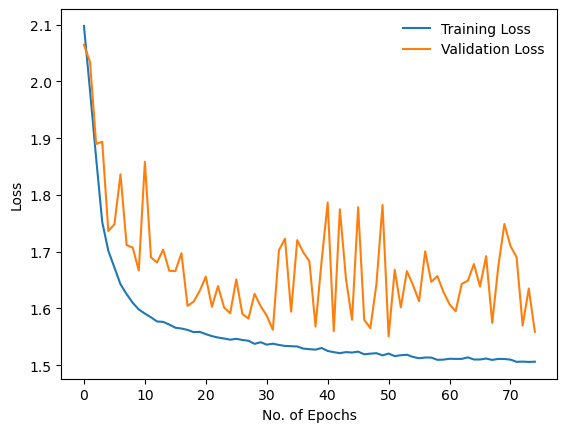

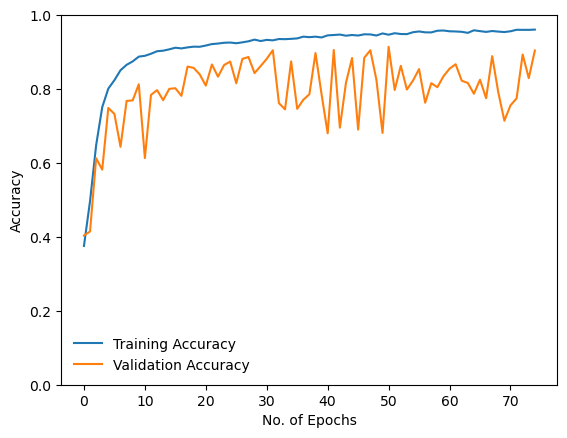

In [200]:
# Assuming train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history are already defined

# Plot training/validation loss
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)
plt.show()

# Plot training/validation accuracy
plt.plot(train_accuracy_history, label="Training Accuracy")
plt.plot(val_accuracy_history, label="Validation Accuracy")
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.ylim([0., 1.]) # Limit y axis between 0 and 1
plt.legend(frameon=False)
plt.show()

In [201]:
test_accuracy, average_test_loss = validate(net, test_loader, loss_function, accuracy_score)
print('Accuracy: %0.2f'% (sum(test_accuracy)/len(test_accuracy)))

Accuracy: 0.91


In [202]:
model_export_path = "./SI_model/"
model_name = 'FRF_multiclass_CNN.pth'
os.makedirs(model_export_path, exist_ok=True)

#Save Pytorch model
def save_net(net, model_path, model_name):
    # Save PyTorch model
    model_full_path = os.path.join(model_path, model_name)
    torch.save(net.state_dict(), model_full_path)
    print(f'Model saved to {model_full_path}')

# Example usage
save_net(net, model_export_path, model_name)

Model saved to ./SI_model/FRF_multiclass_CNN.pth
